# Librairies

In [11]:
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import os
from shapely.geometry import LineString
import zipfile
import numpy as np
import matplotlib.pylab as plt

# Geographical referential

In [12]:
import io
from fiona.io import ZipMemoryFile
# Open the gzip-compressed file
# NB: Sometimes some month are not available

list_gdf = []
# To store the results
for filename in tqdm(os.listdir('raw/')) :
    # Go through each file
    if filename[:14] == 'pmed_ubicacion':
        # It is a sensor location file
        zipshp = io.BytesIO(open('raw/' + filename, 'rb').read())
        with (ZipMemoryFile(zipshp)) as memfile:
            with memfile.open() as src:
                crs = src.crs
                gdf = gpd.GeoDataFrame.from_features(src, crs=crs)
        list_gdf.append(gdf)

100%|██████████| 22/22 [00:03<00:00,  6.53it/s]


In [13]:
gdf = pd.concat(list_gdf)
gdf.shape

(49277, 19)

In [14]:
gdf[gdf.id == 1009].geometry.values

<GeometryArray>
[<POLYGON ((438502.443 4474206.231, 438501.091 4474208.909, 438490.836 447420...>,
 <POLYGON ((438502.443 4474206.231, 438501.091 4474208.909, 438490.836 447420...>,
 <POLYGON ((438502.443 4474206.231, 438501.091 4474208.909, 438490.836 447420...>,
 <POLYGON ((438502.443 4474206.231, 438501.091 4474208.909, 438490.836 447420...>,
 <POLYGON ((438502.443 4474206.231, 438501.091 4474208.909, 438490.836 447420...>,
 <POLYGON ((438502.443 4474206.231, 438501.091 4474208.909, 438490.836 447420...>]
Length: 6, dtype: geometry

In [15]:
# Drop duplicated rows (because there are repetitions each month)
gdf.drop_duplicates(subset = ['id', 'cod_cent', 'nombre'], inplace=True)

In [16]:
# Put it to longitude / Latitude
gdf.to_crs('epsg:4326', inplace=True)

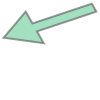

In [17]:
# Transform the geometries into oriented LineStrings
gdf.geometry.values[0]

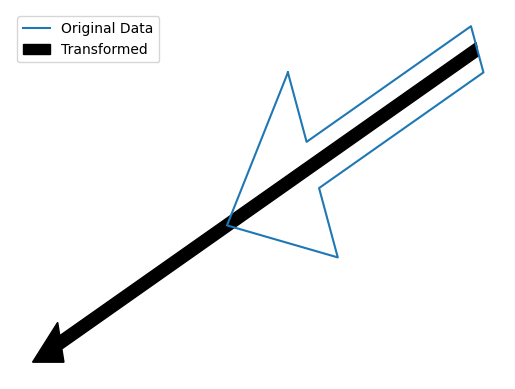

In [18]:
# We should create an oriented linestring geometry from that
arrow_polygon = gdf.geometry.values[0]
coords = list(arrow_polygon.exterior.coords)

# Step 2: Get the centroid of the polygon
centroid = arrow_polygon.centroid

# Step 3: Find the longest diagonal or primary direction
# This uses all edges to find the longest one
edges = [(coords[i], coords[i + 1]) for i in range(len(coords) - 1)]
longest_edge = max(edges, key=lambda edge: LineString(edge).length)

shortest_edge = min(edges, key=lambda edge: LineString(edge).length)

# Step 4: Orient the LineString from centroid to the longest edge's midpoint
midpoint = (
    (longest_edge[0][0] + longest_edge[1][0]) / 2,
    (longest_edge[0][1] + longest_edge[1][1]) / 2,
)

midpoint = (
    (shortest_edge[0][0] + shortest_edge[1][0]) / 2,
    (shortest_edge[0][1] + shortest_edge[1][1]) / 2,
)

# Create the oriented LineString
oriented_line = LineString([midpoint, centroid.coords[0]])

plt.plot(np.array(coords)[: ,0], 
            np.array(coords)[: ,1], 
            zorder = np.inf, label = 'Original Data')

plt.plot()

vector = (np.array(centroid.coords) - np.array(midpoint) )[0]
plt.arrow(x = midpoint[0], 
          y = midpoint[1], 
          dx = vector[0]*3, 
          dy = vector[1]*3, 
          color = 'k', width = 5e-6, label  = 'Transformed')
plt.axis('off')
plt.legend()

In [19]:
def arrow_to_line(arrow_polygon):
    # We should create an oriented linestring geometry from that
    coords = list(arrow_polygon.exterior.coords)

    # Step 2: Get the centroid of the polygon
    centroid = arrow_polygon.centroid

    # Step 3: Find the longest diagonal or primary direction
    # This uses all edges to find the longest one
    edges = [(coords[i], coords[i + 1]) for i in range(len(coords) - 1)]
    shortest_edge = min(edges, key=lambda edge: LineString(edge).length)

    midpoint = (
        (shortest_edge[0][0] + shortest_edge[1][0]) / 2,
        (shortest_edge[0][1] + shortest_edge[1][1]) / 2,
    )
    
    vector = (np.array(centroid.coords) - np.array(midpoint) )[0]
    
    

    # Create the oriented LineString
    return LineString([midpoint, centroid.coords[0], centroid.coords[0]+5*vector])


In [20]:
# Apply to the entire referential
gdf['geometry'] = gdf['geometry'].apply(lambda x : arrow_to_line(x))

In [22]:
gdf.tipo_elem.value_counts()

tipo_elem
URB      4528
M30       308
other     128
Name: count, dtype: int64

# Traffic data

In [27]:
# We provide an example for 2024 as the data is heavy (~80Mo compressed per month)
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
# There is an error in Sept 2024 the file in the zip archive is named '09_2024' ; we changed that
# Read and filter data
list_df = list()
for month in tqdm(months) :
    filename = month + '-2024'
    # Open the zip-compressed files
    with zipfile.ZipFile(f'raw/{filename}.zip', 'r') as z:
        with z.open(filename + '.csv') as f :
            # Get only id, time, flow and speed columns to reduce memory usage
            df = pd.read_csv(f, delimiter = ';', usecols=[0, 1, 3, 6])
            df.fecha = pd.to_datetime(df.fecha)
            
            # Intensidad: Número de vehículos en el periodo de 15 minutos, expresada en vehículos/hora. 
            # El valor efectivo de vehículos que han circulado en ese periodo se obtiene dividiendo entre cuatro. 
            # Un valor negativo implica la ausencia de datos.
            
            # Replace null values with nan values
            df.loc[df.vmed <=0, 'vmed'] = np.nan
            
            # Group by id and aggregate the flow hourly (intensidad is already in veh/hour)
            df = df.set_index('fecha').groupby('id').resample('h').agg(flow = ('intensidad', 'mean'), speed = ('vmed', 'mean'))
            list_df.append(df)
# Concatenate each month into a single df
df = pd.concat(list_df)

100%|██████████| 12/12 [05:20<00:00, 26.68s/it]


In [28]:
list_df = None

In [29]:
# Now we need to go from hourly data to AADT
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from temporal_agg import hourly_to_aadt


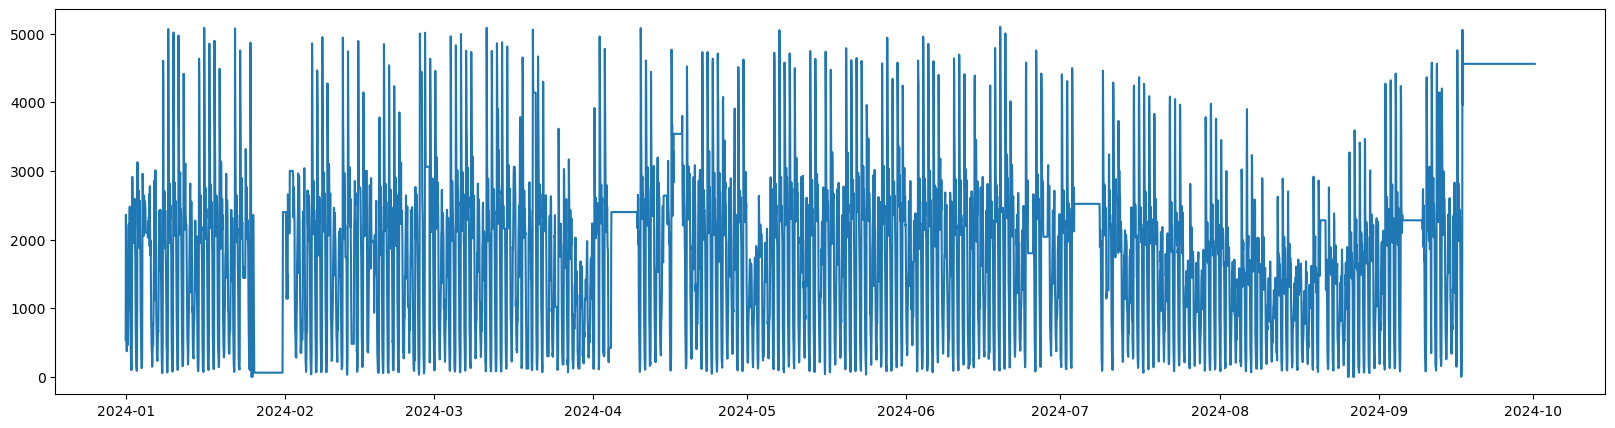

In [30]:
plt.figure(figsize = (20,5))
plt.plot(df.loc[1001].flow)

In [31]:
# Apply our function - can be long ~40M rows (took 18min)
df = hourly_to_aadt(df, 
                    sensor_id_name = 'id', time_name = 'fecha', 
                    counts_name = ['flow'], speeds_name = {'speed':'flow'})

In [32]:
df

,flow,speed,flow_AAWT,speed_AAWT
id,,,,
1001,44372.280109,58.952767,47186.607143,58.911679
1002,42306.490196,63.239507,44714.839450,63.061286
1003,53171.056389,60.956505,56692.492601,60.541663
1006,43070.619198,64.637661,45908.771755,64.268766
1009,41522.808808,60.963807,44429.712758,59.990880
...,...,...,...,...
11382,11410.369048,57.186554,10770.819444,56.732857
11383,16557.547619,80.369459,17509.241667,79.582064
11384,12172.708333,70.004865,11773.000000,70.565824


In [33]:
df.isna().sum()

flow           0
speed         12
flow_AAWT      1
speed_AAWT    13
dtype: int64

In [34]:
# Set 0 speeds to NaN
df.loc[df.speed <=0, 'speed'] = np.nan

In [35]:
df.shape

(4772, 4)

In [36]:
df = df.join(gdf.set_index('id')[['nombre', 'geometry']], how = 'inner')

In [37]:
df = df.drop('speed_AAWT', axis=1).rename(columns = 
                                     {
                                         'flow':'AADT',
                                         'speed':'savg',
                                         'flow_AAWT':'AAWT',
                                         'nombre' : 'Street_name'
                                     }
                                     )
df

,AADT,savg,AAWT,Street_name,geometry
id,,,,,
1001.0,44372.280109,58.952767,47186.607143,05FT10PM01,"LINESTRING (-3.74087 40.40968, -3.74079 40.409..."
1002.0,42306.490196,63.239507,44714.839450,05FT37PM01,"LINESTRING (-3.74385 40.40799, -3.74376 40.408..."
1003.0,53171.056389,60.956505,56692.492601,05FT66PM01,"LINESTRING (-3.74693 40.40679, -3.74683 40.406..."
1006.0,43070.619198,64.637661,45908.771755,04FT74PM01,"LINESTRING (-3.73643 40.41186, -3.73632 40.411..."
1009.0,41522.808808,60.963807,44429.712758,03FT52PM01,"LINESTRING (-3.72501 40.41619, -3.72491 40.416..."
...,...,...,...,...,...
11317.0,11176.895833,NaN,11748.497239,Av. Guadalajara 53 - RepÃºblica Checa-Bulgaria,"LINESTRING (-3.61877 40.42001, -3.61887 40.419..."
11318.0,3378.684436,NaN,3540.428615,San Roman del Valle 20 - Arcos del Jalon-Guada...,"LINESTRING (-3.62113 40.42002, -3.62108 40.419..."
11319.0,5270.319133,NaN,5874.714361,Av Canillejas a Vicalvaro - Pobladura del Vall...,"LINESTRING (-3.61121 40.42791, -3.61123 40.427..."


# Map Matching with OSM

In [38]:
from map_matching_OSM import lines_matching

In [39]:
df = gpd.GeoDataFrame(
    df,
    geometry='geometry',
    crs = 'epsg:4326'
)

In [40]:
df = lines_matching(df.reset_index()) #(5min)
# reset index because of the duplicated ones

Main graph loaded
Node 1545822083 not reachable from 957891097
Node 293506960 not reachable from 957891097
Node 35139744 not reachable from 957891097
Node 310588004 not reachable from 957891097
Node 628002665 not reachable from 957891097
Node 35139744 not reachable from 957891097
Node 809991537 not reachable from 957891097
Node 119947648 not reachable from 957891097
Node 90912291 not reachable from 957891097
Node 1545822083 not reachable from 276507223
Node 293506960 not reachable from 276507223
Node 35139744 not reachable from 276507223
Node 310588004 not reachable from 276507223
Node 628002665 not reachable from 276507223
Node 35139744 not reachable from 276507223
Node 809991537 not reachable from 276507223
Node 119947648 not reachable from 276507223
Node 90912291 not reachable from 276507223
Node 1545822083 not reachable from 35139744
Node 293506960 not reachable from 35139744
Node 310588004 not reachable from 35139744
Node 628002665 not reachable from 35139744
Node 809991537 not re

In [42]:
df[['Street_name', 'osm_name']].drop_duplicates()[-40:]

,Street_name,osm_name
4715,Secundino Zuazo (CARRIL BUS) - Josefina Aldeco...,Glorieta de Francisco Jareño
4716,Niceto Alcala Zamora S-N junto a EMT - M-11 -...,Avenida de Niceto Alcalá Zamora
4717,STA MARIA MAGDALENA N-S,Calle de Santa María Magdalena
4718,TORPEDERO TUCUMAN N-S,Calle del Torpedero Tucumán
4719,ALFONSO XIII (GIRO A STA MÂªMAGDALENA)JOSE MÂª...,Avenida de Alfonso XIII
4720,"CARRIL BUS_Av Niza, 43 - MÂª Sevilla Diago-Jul...",Avenida de Niza
4721,"Av Niza, 43 - MÂª Sevilla Diago-Julia Garcia B...",Avenida de Niza
4722,"Julia Garcia Boutan, 26 - Niza-Suecia",Calle de Julia García Boután
4723,"Julia Garcia Boutan, 12 - Longares-Niza",Calle de Julia García Boután
4724,"Niza, 67 - Plz Grecia-MÂª Sevilla Diago",Avenida de Niza


In [43]:
df.columns

Index(['id', 'AADT', 'savg', 'AAWT', 'Street_name', 'geometry', 'osm_name',
       'osm_type', 'osm_lanes', 'osm_oneway', 'osmid'],
      dtype='object')

In [44]:
df.rename(columns = {'Street_name':'raw_name'}, inplace=True)

In [45]:
df['raw_oneway'] = True

# Final save

In [46]:
df.drop(['id'], axis = 1)[['AADT', 'AAWT', 'savg', 'raw_name', 'raw_oneway', 'geometry', 'osm_name',
       'osm_type', 'osm_lanes', 'osm_oneway', 'osmid']].to_file('treated/Madrid_AADT_AAWT_2024.geojson')